In [1]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import obspy
import datetime
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
# Adding pyDAS location
pyDAS_path = "/home/yinjx/DAS-utilities/build/"
import os
try:
    os.environ['LD_LIBRARY_PATH'] += ":" + pyDAS_path
except:
    os.environ['LD_LIBRARY_PATH'] = pyDAS_path
import sys
sys.path.insert(0,pyDAS_path)
sys.path.insert(0,'/home/yinjx/DAS-utilities/python')
import DASutils
import importlib
importlib.reload(DASutils)

<module 'DASutils' from '/home/ebiondi/research/packages/DAS-proc/python/DASutils.py'>

In [3]:
# load the DAS channel location
DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Olancha_Plexus.txt')

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info[:, 0].astype('int')
DAS_lon = DAS_info[:, 1]
DAS_lat = DAS_info[:, 2]

In [4]:
# Define the path to store all the output results
output_dir = '/home/yinjx/kuafu/Olancha_Plexus'

In [5]:
import glob
data_dir = '/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/'

files = glob.glob(data_dir + '/*.h5')
files.sort()

# Only keep the "COMPLETE" data with size > 5G
files = [file for file in files if os.path.getsize(file)/1e9 > 5] 
file_names = [os.path.basename(file) for file in files]

print(f'Total file number: {len(files)}')
print(f'Total file number: {len(file_names)}')
print(file_names[0])
print(file_names[-1])

Total file number: 5287
Total file number: 5287
Olancha-2020-06-26 025129Z.h5
Olancha-2021-07-19T120640Z.h5


In [6]:
# Prepare a DataFrame to include the DAS files and corresponding Time information
file_UTCDateTime_tbeg = []
instrument_type_all = []

for ii, file in enumerate(file_names):
    file_UTCDateTime_tbeg.append(obspy.UTCDateTime(file[8:-3]))
    if 'T' in file:
        instrument_type_all.append('new')
    else:
        instrument_type_all.append('old')
    
    
df_files = pd.DataFrame(columns=['files_abs', 'file_name', 't_begin', 'instrument_type'])
df_files.files_abs = files
df_files.file_name = file_names
df_files.t_begin = file_UTCDateTime_tbeg
df_files.instrument_type = instrument_type_all

In [7]:
df_files.to_csv(output_dir + '/data_file_list.csv')

In [8]:
# For now, only look at the old data files (because they have locations...)
df_files_old = df_files[df_files.instrument_type == 'old']
df_files_old

,files_abs,file_name,t_begin,instrument_type
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old
1,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 035047Z.h5,2020-06-26T03:50:47.000000Z,old
2,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 045047Z.h5,2020-06-26T04:50:47.000000Z,old
3,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 055047Z.h5,2020-06-26T05:50:47.000000Z,old
4,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 065047Z.h5,2020-06-26T06:50:47.000000Z,old
...,...,...,...,...
2679,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 003843Z.h5,2021-02-27T00:38:43.000000Z,old
2680,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 013843Z.h5,2021-02-27T01:38:43.000000Z,old
2681,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 023843Z.h5,2021-02-27T02:38:43.000000Z,old
2682,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 033843Z.h5,2021-02-27T03:38:43.000000Z,old


In [9]:
# convert the phase shift to strain given a gauge length
def phase_to_strain(phase, L=16):
    strain = phase * 1550.12 * 1e-9 / (0.78 * 2 * np.pi * 1.46 * L)
    return strain

In [13]:
# Define some reusable functions
def plot_data(DAS_dataS, title='Data'):
    # visualize the data every 5 mins
    fig, ax1 = plt.subplots(figsize=(16,8))
    pclip=98
    clipVal = np.percentile(np.absolute(DAS_dataS), pclip)
    # Vx
    ax1.imshow(DAS_dataS.T, 
               extent=[0, DAS_dataS.shape[0]-1, tAx_secS[-1], tAx_secS[0]],
               aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))
    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()
    ax1.set_title(title)
    
    return fig

### First read the catalog, the catalog is from STP with command:

```bash
EVENT -mag 2.0 8.0 -lat 33.65 37.65 -lon -119.72 -115.72 -t0 2019/7/10,18:00:00 2021/6/5,18:00:00 -f Ridgecrest_das_catalog_M2_M8.txt
```

In [10]:
catalog_file = '/home/yinjx/notebooks/Ridgecrest/Ridgecrest_das_catalog_M2_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog

,0,1,2,3,4,5,6,7,8,9
0,38521207,eq,l,"2019/07/10,18:00:01.250",35.7753,-117.6033,7.59,2.26,l,1.0
1,38521231,eq,l,"2019/07/10,18:01:27.840",35.6733,-117.5210,5.71,2.37,l,1.0
2,38521351,eq,l,"2019/07/10,18:11:09.650",35.7067,-117.5282,9.24,2.02,l,1.0
3,38521591,eq,l,"2019/07/10,18:30:10.250",35.6533,-117.5022,7.97,2.42,l,1.0
4,38521775,eq,l,"2019/07/10,18:44:42.310",35.6738,-117.5278,8.65,2.17,l,1.0
...,...,...,...,...,...,...,...,...,...,...
4409,39914032,eq,l,"2021/06/02,07:44:21.310",35.9512,-117.3327,3.37,2.16,l,1.0
4410,39915440,eq,l,"2021/06/03,04:48:33.690",34.3058,-116.9277,8.38,2.27,l,1.0
4411,39915912,eq,l,"2021/06/03,15:52:48.420",33.9922,-117.0828,16.10,2.13,l,1.0
4412,39916960,eq,l,"2021/06/04,12:18:09.310",33.9017,-116.1048,9.01,2.49,l,1.0


In [16]:
catalog_select = catalog[(catalog[7] >= 3) & (catalog[6] > 1)] # choose the event with magnitude > 3.5
#catalog_select = catalog[(catalog[7] >= 3) & (catalog[7] <= 3.5) & (catalog[6] > 1)] # choose the event with magnitude <= 3.5

In [17]:
eq_num = catalog_select.shape[0]
eq_id = np.array(catalog_select[0])
eq_time = np.array(catalog_select[3])
eq_lat = np.array(catalog_select[4])
eq_lon = np.array(catalog_select[5])
eq_dep = np.array(catalog_select[6])
eq_mag = np.array(catalog_select[7])

print(f'Total number of events: {eq_num}')

Total number of events: 452


In [18]:
catalog_select

,0,1,2,3,4,5,6,7,8,9
7,38521799,eq,l,"2019/07/10,18:49:01.420",36.1662,-117.8825,1.12,4.09,w,1.0
9,38521815,eq,l,"2019/07/10,18:51:35.250",36.1695,-117.8750,2.27,3.70,w,1.0
10,37265572,eq,l,"2019/07/10,18:51:43.830",36.0553,-117.8542,7.76,3.51,l,1.0
14,38522055,eq,l,"2019/07/10,19:15:02.530",36.1213,-117.8287,2.65,3.25,l,1.0
15,37248948,eq,l,"2019/07/10,19:15:14.920",35.3467,-117.9205,4.62,3.18,l,1.0
...,...,...,...,...,...,...,...,...,...,...
4345,39645599,eq,l,"2021/05/09,01:55:40.450",33.8453,-118.4490,11.84,3.45,lr,1.0
4347,39645767,eq,l,"2021/05/09,09:09:33.800",34.0265,-117.2335,16.29,3.03,l,1.0
4368,39659271,eq,l,"2021/05/20,01:37:22.690",35.9748,-117.3245,3.04,3.59,w,1.0
4385,39905824,eq,l,"2021/05/26,21:12:12.490",34.3427,-119.6487,11.45,3.31,l,1.0


In [19]:
# TODO: Find a good way to handle the file names ...
# Convert the event time to obspy UTCDateTime and also find the corresponding DAS file name
import datetime
import obspy

# event time in obspy.UTCDateTime
eq_time_UTCDateTime = [obspy.UTCDateTime(temp) for temp in eq_time]

In [20]:
eq_time_UTCDateTime[370]

2020-07-24T07:05:13.560000Z

In [21]:
df_files_old

,files_abs,file_name,t_begin,instrument_type
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old
1,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 035047Z.h5,2020-06-26T03:50:47.000000Z,old
2,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 045047Z.h5,2020-06-26T04:50:47.000000Z,old
3,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 055047Z.h5,2020-06-26T05:50:47.000000Z,old
4,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 065047Z.h5,2020-06-26T06:50:47.000000Z,old
...,...,...,...,...
2679,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 003843Z.h5,2021-02-27T00:38:43.000000Z,old
2680,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 013843Z.h5,2021-02-27T01:38:43.000000Z,old
2681,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 023843Z.h5,2021-02-27T02:38:43.000000Z,old
2682,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-02-27 033843Z.h5,2021-02-27T03:38:43.000000Z,old


In [22]:
i_data_found = 0
data_found_df = pd.DataFrame()
eq_index = []

for i_eq, eq_time in enumerate(eq_time_UTCDateTime):
    try:
        ii = (df_files_old.t_begin < eq_time) & (df_files_old.t_begin > eq_time - 3600)
        event_found = df_files_old[ii].copy()
        if len(event_found) > 0:
            eq_index.append(i_eq)
            event_found['eq_id'] = eq_id[i_eq]
            event_found['eq_time'] = eq_time
            data_found_df = pd.concat([data_found_df, event_found])
            i_data_found += 1
            print('=' * 10 + str(i_data_found) + '=' * 10)
            print(f'Event time: {eq_time}')
            print(f'Data begin time: {event_found.t_begin}')
    except:
        continue

==========1==========
Event time: 2020-06-29T01:55:49.010000Z
Data begin time: 58    2020-06-29T01:23:22.000000Z
Name: t_begin, dtype: object
==========2==========
Event time: 2020-07-02T18:49:41.090000Z
Data begin time: 147    2020-07-02T18:32:07.000000Z
Name: t_begin, dtype: object
==========3==========
Event time: 2020-07-14T12:15:18.870000Z
Data begin time: 385    2020-07-14T11:49:29.000000Z
Name: t_begin, dtype: object
==========4==========
Event time: 2020-07-20T22:01:53.080000Z
Data begin time: 538    2020-07-20T21:37:38.000000Z
Name: t_begin, dtype: object
==========5==========
Event time: 2020-07-23T00:29:26.230000Z
Data begin time: 588    2020-07-22T23:37:38.000000Z
Name: t_begin, dtype: object
==========6==========
Event time: 2020-07-24T07:05:13.560000Z
Data begin time: 619    2020-07-24T06:30:00.000000Z
Name: t_begin, dtype: object
==========7==========
Event time: 2020-08-21T08:20:08.360000Z
Data begin time: 735    2020-08-21T07:26:37.000000Z
Name: t_begin, dtype: object


In [23]:
data_found_df.to_csv(output_dir + '/selected_events_and_das_files_6250_data.csv')

### Show a simple map for the DAS array and events

In [24]:
catalog_select0 = catalog_select[catalog_select[0].isin(data_found_df.eq_id)]
catalog_select0

eq_num = catalog_select0.shape[0]
eq_id = np.array(catalog_select0[0])
eq_time = np.array(catalog_select0[3])
eq_lat = np.array(catalog_select0[4])
eq_lon = np.array(catalog_select0[5])
eq_dep = np.array(catalog_select0[6])
eq_mag = np.array(catalog_select0[7])

print(f'Total number of events: {eq_num}')
catalog_select0.to_csv(output_dir + '/selected_events_info_6250_data.csv')

Total number of events: 30


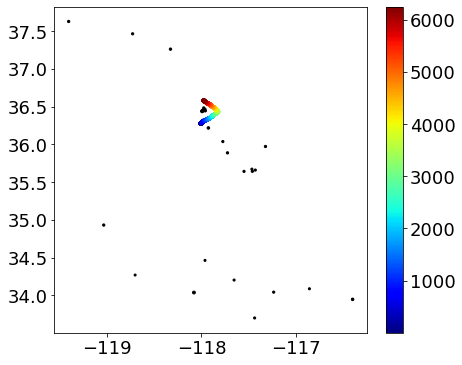

In [25]:
# TODO: add an inset with Zoom-in DAS channels
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(eq_lon, eq_lat, s=10**(eq_mag/5), c='k')
fig.colorbar(cmp)

### Calculate the arrival time from earthquake to each das channel using 1D velocity model. If the travel time table has already been calculated, load the prepared travel time table, calculate the interpolation function to estimate the arrival times.

In [22]:
# Work out a handy travel time table to do interpolation
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

travel_time_table_file = output_dir + '/travel_time_table_Olancha.npz'

# from one event to all channels
event_arrival_P = np.zeros((DAS_channel_num, eq_num)) 
event_arrival_S = np.zeros((DAS_channel_num, eq_num)) 

# First look for the precalculated TTT, if not exists, get one from interpolating TauP 
if not os.path.exists(travel_time_table_file):
    model = TauPyModel(model='iasp91')

    # distance list
    distance_fit = np.linspace(0, 3, 100)
    # depth list
    depth_fit = np.arange(0, 100, 1)

    distance_grid, depth_grid = np.meshgrid(distance_fit, depth_fit)


    tavel_time_P_grid = np.zeros(distance_grid.shape)
    tavel_time_S_grid = np.zeros(distance_grid.shape)

    #for i_eq in tqdm.tqdm(range(10), desc="Calculating arrival time..."):
    for i_depth in tqdm.tqdm(range(depth_grid.shape[0]), desc="Calculating arrival time..."):   

        for i_distance in range(distance_grid.shape[1]):
            try:
                arrivals = model.get_ray_paths(depth_fit[i_depth], distance_fit[i_distance], phase_list=['p', 's'])
                tavel_time_P_grid[i_depth, i_distance] = arrivals[0].time
                tavel_time_S_grid[i_depth, i_distance] = arrivals[1].time 
            except:
                tavel_time_P_grid[i_depth, i_distance] = np.nan
                tavel_time_S_grid[i_depth, i_distance] = np.nan

    # save the calculated Travel time table
    np.savez(travel_time_table_file, distance_grid=distance_grid, depth_grid=depth_grid, 
             tavel_time_p_grid=tavel_time_P_grid, tavel_time_s_grid=tavel_time_S_grid)

    print('Travel time table calculated!')
    
    
# The TTT calculated or already exists, directly load it.
temp = np.load(travel_time_table_file)
distance_grid = temp['distance_grid']
depth_grid = temp['depth_grid']
tavel_time_p_grid = temp['tavel_time_p_grid']
tavel_time_s_grid = temp['tavel_time_s_grid']

# build the interpolation function
from scipy.interpolate import interp2d
#grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

ii = ~np.isnan(tavel_time_p_grid) # ignore the nan
interp_f_p = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_p_grid[ii], kind='linear')
interp_f_s = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_s_grid[ii], kind='linear')

for i_eq in tqdm.tqdm(range(eq_num), desc="Calculating arrival time..."):   
    # estimate the arrival time of each earthquake to all channels
    P_arrival = np.zeros(DAS_channel_num)
    S_arrival = np.zeros(DAS_channel_num)
    distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_eq], eq_lon[i_eq])

    P_arrival = data_found_df['eq_time'].iloc[i_eq] - data_found_df['t_begin'].iloc[i_eq] + interp_f_p(distance_to_source, eq_dep[i_eq])
    S_arrival = data_found_df['eq_time'].iloc[i_eq] - data_found_df['t_begin'].iloc[i_eq] + interp_f_s(distance_to_source, eq_dep[i_eq])  


    event_arrival_P[:, i_eq] = P_arrival
    event_arrival_S[:, i_eq] = S_arrival

/home/yinjx/.conda/envs/das_data/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=96,101 m=9243 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/yinjx/.conda/envs/das_data/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=96,101 m=9243 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
Calculating arrival time...: 100%|█████████████| 30/30 [00:00<00:00, 512.04it/s]


i_file = 1150 # Before 2683 are the old data

files_abs_path = df_files.files_abs[i_file]
file_name = df_files.file_name[i_file]
t_begin = df_files.t_begin[i_file]
instrument_type = df_files.instrument_type[i_file]

DAS_dataS, info = DASutils.readFile_HDF([files_abs_path], 0.01, 20.0, taper=0.0,
                                        verbose=1, desampling=True, system="OptaSense", nChbuffer=5000)

if instrument_type == 'old': # For the old instruments, the data is phase shift, conversion is needed.
    print('conversion is needed!')
    DAS_dataS = phase_to_strain(DAS_dataS)

ntS = info['nt']
fs = info['fs']
dt = info['dt']
tAx_secS = np.linspace(0.0, (ntS-1)*dt, ntS)

# To strain rate
DAS_dataS = np.diff(DAS_dataS[:, :], axis=1)/dt
tAx_secS = tAx_secS[:-1] + dt/2
ntS = ntS - 1

In [23]:
data_found_df

,files_abs,file_name,t_begin,instrument_type,eq_id,eq_time
58,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-29 012322Z.h5,2020-06-29T01:23:22.000000Z,old,39271783,2020-06-29T01:55:49.010000Z
147,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-02 183207Z.h5,2020-07-02T18:32:07.000000Z,old,39276943,2020-07-02T18:49:41.090000Z
385,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-14 114929Z.h5,2020-07-14T11:49:29.000000Z,old,39292639,2020-07-14T12:15:18.870000Z
538,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-20 213738Z.h5,2020-07-20T21:37:38.000000Z,old,38599882,2020-07-20T22:01:53.080000Z
588,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-22 233738Z.h5,2020-07-22T23:37:38.000000Z,old,38603762,2020-07-23T00:29:26.230000Z
619,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-24 063000Z.h5,2020-07-24T06:30:00.000000Z,old,38605954,2020-07-24T07:05:13.560000Z
735,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-08-21 072637Z.h5,2020-08-21T07:26:37.000000Z,old,39587168,2020-08-21T08:20:08.360000Z
1026,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-09-02 152905Z.h5,2020-09-02T15:29:05.000000Z,old,39368535,2020-09-02T16:18:31.660000Z
1070,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-09-04 112905Z.h5,2020-09-04T11:29:05.000000Z,old,38675290,2020-09-04T11:39:18.200000Z
1072,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-09-04 132905Z.h5,2020-09-04T13:29:05.000000Z,old,38675450,2020-09-04T14:24:44.100000Z


### Output the windowed data for ML phase/arrival time picking

In [27]:
DAS_index

array([   1,    2,    3, ..., 6248, 6249, 6250])

In [36]:
# Save the segmented data for ML phase picking
data_folder = output_dir + '/ML_picking_data_M_3+'
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

for i_event in tqdm.tqdm(range(2, eq_num), desc="Extracting waveforms..."):
#     try:
    data0, info = DASutils.readFile_HDF([data_found_df.files_abs.iloc[i_event]], 0.01, 20.0, taper=0.0,
                                    verbose=1, desampling=True, system="OptaSense", nChbuffer=5000)

    ntS = info['nt']
    fs = info['fs']
    das_dt = info['dt']
    das_time = np.linspace(0.0, (ntS-1)*das_dt, ntS)


    data0 = phase_to_strain(data0)
    data0 = data0[DAS_index-1, :]
    data_diff = np.diff(data0, axis=1)/das_dt

    # time information 
    das_time = das_time[:-1] + das_dt/2

    # cut the data
    t_begin = np.min(event_arrival_P[:, i_event]) - 10
    t_end = np.max(event_arrival_S[:, i_event]) + 60

    # segmented data
    ii_time = (das_time >= t_begin) & (das_time <= t_end)
    data_diff = data_diff[:, ii_time]
    das_time = das_time[ii_time]   

    # Downsample from 250 Hz to 50 Hz
    data = data_diff.T
    np.savez(data_folder + f'/{eq_id[i_event]}.npz', data=data)


    # Show data
    fig, ax1 = plt.subplots(figsize=(16,8))
    pclip=99.5
    clipVal = np.percentile(np.absolute(data_diff), pclip)
    # Vx
    ax1.imshow(data_diff.T, 
               extent=[0, data_diff.shape[0], das_time[-1], t_begin],
               aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

    ax1.plot(DAS_index, event_arrival_P[::-1, i_event], '--g', zorder=10)
    ax1.plot(DAS_index, event_arrival_S[::-1, i_event], '-g', zorder=10)

    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()

    plt.savefig(data_folder + f'/{eq_id[i_event]}.png')
    plt.close('all')
        
#     except:
#         print(f'data of event {eq_id[i_event]} not found')
#         continue

Processing data...: 100%|█████████████████████████| 2/2 [01:09<00:00, 34.50s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:02<00:00, 31.31s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:06<00:00, 33.35s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:06<00:00, 33.26s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:07<00:00, 33.93s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:05<00:00, 32.92s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:10<00:00, 35.42s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:16<00:00, 38.27s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:03<00:00, 31.66s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:00<00:00, 30.12s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:03<00:00, 31.91s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [00:44<00:00, 22.42s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:02<00:00, 31.22s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:05<00:00, 32.79s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [00:58<00:00, 29.38s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:04<00:00, 32.46s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:03<00:00, 31.95s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [00:42<00:00, 21.48s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:05<00:00, 32.76s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:02<00:00, 31.48s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:01<00:00, 30.61s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:01<00:00, 30.81s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [00:54<00:00, 27.23s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:01<00:00, 30.99s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:14<00:00, 37.14s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:27<00:00, 43.88s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:23<00:00, 41.62s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Processing data...: 100%|█████████████████████████| 2/2 [01:06<00:00, 33.11s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


Extracting waveforms...: 100%|██████████████████| 28/28 [35:55<00:00, 76.99s/it]


### Wait for ML results from Weiqiang. TODO: trying to include his code here to directly refind the time picking.

### Load the ML-picked arrival time, and check how the ML picking works

In [26]:
from scipy.interpolate import interp1d

def extrapolate_arrival_time(ml_picks, kind='linear'):
    channel = np.array(ml_picks['station_name'])
    phase_index = np.array(ml_picks['phase_index'])
    channel_all = np.arange(0, DAS_channel_num)

    interp_f = interp1d(channel, phase_index, kind=kind, fill_value='extrapolate')
    phase_index_extrap = interp_f(channel_all).astype('int')
    return phase_index_extrap

In [52]:
extrapolate_ml_picking = True

# path of the ML picking 
ml_pick_dir = '/net/arius/scratch/zhuwq/Mask2Former/picks_yinjx_olancha_m3'
data_folder = output_dir + '/ML_picking_data_M_3+'
# Check the segmented 50Hz data
das_path = data_folder#'/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for eq_id_current in eq_id:
      
    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')

        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = ml_picks_p['phase_index']
            event_arrival_S_ml_index = ml_picks_s['phase_index']
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index]

        # Show data
        fig, ax1 = plt.subplots(figsize=(16,8))
        pclip=99.5
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        # Vx
        ax1.imshow(data_diff, 
                   extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
                   aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1.plot(event_arrival_P_ml, '--k', linewidth=2, zorder=10)
        ax1.plot(event_arrival_S_ml, '-k', linewidth=2, zorder=10)

        ax1.set_title(f'Event ID: {eq_id_current}')
        ax1.set_xlabel("Channel number")
        ax1.set_ylabel("Time [s]")
        ax1.grid()

        plt.savefig(das_path + '/' + fig_name)
        plt.close('all')
        print(f'Event {eq_id_current} done!')
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

Event 39271783 done!
Event 39276943 done!
Event 39292639 done!
Event 38599882 done!
Event 38603762 done!
Event 38605954 done!
Event 39587168 done!
Event 39368535 done!
Event 38675290 done!
ML picking 38675450 not found, skip...
Event 38676562 done!
Event 38683914 done!
Event 38683930 done!
Event 38683938 done!
Event 38693130 done!
Event 38695658 done!
ML picking 38697738 not found, skip...
ML picking 38700978 not found, skip...
ML picking 38703786 not found, skip...
ML picking 38703802 not found, skip...
Event 39649656 done!
Event 39651712 done!
Event 39455887 done!
ML picking 39466855 not found, skip...
Event 39466903 done!
ML picking 39477655 not found, skip...
Event 39550567 done!
Event 39551831 done!
Event 39552143 done!
ML picking 39803176 not found, skip...


### Now use the ML pick time to extract maximum amplitude

In [27]:
# apply mask onto the data
def extract_maximum_amplitude(time_list, data_matrix, t1, t2):
    t1 = t1[:, np.newaxis]
    t2 = t2[:, np.newaxis]
    time_list = time_list[np.newaxis, :]
    
    # broadcast comparison
    mask_index = (time_list >= t1) & (time_list < t2)
    data_matrix_mask = data_matrix.copy()
    data_matrix_mask[~mask_index] = np.nan
    max_amplitude = np.nanmax(data_matrix_mask, axis=1)
    return max_amplitude


In [28]:
from scipy.signal import butter, filtfilt

def convert_to_strain(strain_rate, das_time, filt=True, filt_freq=0.5):
    dt = das_time[1] - das_time[0]
    strain_temp = np.cumsum(strain_rate * das_time, axis=1)
    if filt:
        aa, bb = butter(2, filt_freq * 2 * dt, btype='high')
        strain_temp = filtfilt(aa, bb, strain_temp, axis=1)
        
    return strain_temp

In [34]:
extrapolate_ml_picking = True
# path of the ML picking 
ml_pick_dir = '/net/arius/scratch/zhuwq/Mask2Former/picks_yinjx_olancha_m3'
data_folder = output_dir + '/ML_picking_data_M_3+'
# Check the segmented 50Hz data
das_path = data_folder#'/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/ML_picking_data_eye_picked'

from obspy.geodetics import locations2degrees

# extract the maximum amplitude
peak_ampliutde_P_all = []
peak_ampliutde_S_all = []
peak_strain_P_all = [] # strain
peak_strain_S_all = [] # strain
distance_all = []
magnitude_all = []
event_id_all = []
channel_id_all = []

das_dt = 0.02 # downsampled to 50 Hz
for i_event, eq_id_current in enumerate(eq_id):
      
    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        # extrapolate the index in case the ML picking is imcomplete
        event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p)
        event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s)
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')

        else:
            raise NameError('Not implemented yet!')
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = ml_picks_p['phase_index']
            event_arrival_S_ml_index = ml_picks_s['phase_index']
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']

    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index]

        end_time = np.ones(event_arrival_S_ml.shape) * das_time[-1]

        data_diff = data_diff.T
        # Extract the maximum given the P and S arrival time
        max_P_amplitude = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_amplitude = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_S_ml, end_time)

        # Also extract strain maximum
        strain = convert_to_strain(data_diff, das_time)
        # Extract the maximum strain given the P and S arrival time
        max_P_strain = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_strain = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_S_ml, end_time)

        # strain to nanostrain
        max_P_amplitude = max_P_amplitude * 1e9
        max_S_amplitude = max_S_amplitude * 1e9
        max_P_strain = max_P_strain * 1e9
        max_S_strain = max_S_strain * 1e9


        # Distance from each channel to the source
        distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_event], eq_lon[i_event])

        # Magnitude of each earhtquake
        magnitude_all.append(np.ones(DAS_lat.shape) * eq_mag[i_event])
        # A simple event label
        event_id_all.append((np.ones(DAS_lat.shape) * eq_id_current).astype('int'))
        # Channel id
        channel_id_all.append(DAS_index)


        peak_ampliutde_P_all.append(max_P_amplitude)
        peak_ampliutde_S_all.append(max_S_amplitude)
        peak_strain_P_all.append(max_P_strain)
        peak_strain_S_all.append(max_S_strain)
        distance_all.append(distance_to_source)
        print('=' * 10 + f'Event {eq_id_current} done!' + '=' * 10)
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

==========Event 39271783 done!==========
==========Event 39276943 done!==========


/tmp/ipykernel_86897/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39292639 done!==========
==========Event 38599882 done!==========


/tmp/ipykernel_86897/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38603762 done!==========
==========Event 38605954 done!==========
==========Event 39587168 done!==========
==========Event 39368535 done!==========
==========Event 38675290 done!==========
ML picking 38675450 not found, skip...
==========Event 38676562 done!==========
==========Event 38683914 done!==========
==========Event 38683930 done!==========
==========Event 38683938 done!==========
==========Event 38693130 done!==========
==========Event 38695658 done!==========
ML picking 38697738 not found, skip...
ML picking 38700978 not found, skip...
ML picking 38703786 not found, skip...
ML picking 38703802 not found, skip...
==========Event 39649656 done!==========
==========Event 39651712 done!==========


/tmp/ipykernel_86897/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39455887 done!==========
ML picking 39466855 not found, skip...
==========Event 39466903 done!==========
ML picking 39477655 not found, skip...
==========Event 39550567 done!==========
==========Event 39551831 done!==========
==========Event 39552143 done!==========
ML picking 39803176 not found, skip...


### Flatten all the measured results. Output all the results.

In [35]:
peak_ampliutde_P_all_flatten = np.array(peak_ampliutde_P_all).flatten()
peak_ampliutde_S_all_flatten = np.array(peak_ampliutde_S_all).flatten()
peak_strain_P_all_flatten = np.array(peak_strain_P_all).flatten()
peak_strain_S_all_flatten = np.array(peak_strain_S_all).flatten()
distance_all_flatten = np.array(distance_all).flatten()
distance_all_km_flatten = distance_all_flatten * 113
magnitude_all_flatten = np.array(magnitude_all).flatten()
event_id_all_flatten = np.array(event_id_all).flatten()
channel_id_all_flatten = np.array(channel_id_all).flatten()

In [36]:
output_file_name = output_dir + '/peak_amplitude_M3+.csv'

all_combined = np.array([event_id_all_flatten, 
                         magnitude_all_flatten, 
                         distance_all_km_flatten, 
                         peak_ampliutde_P_all_flatten, 
                         peak_ampliutde_S_all_flatten,
                         peak_strain_P_all_flatten,
                         peak_strain_S_all_flatten,
                         channel_id_all_flatten]).T

peak_amplitude_df = pd.DataFrame(data=all_combined, 
                                 columns=['event_id', 'magnitude', 'distance_in_km', 'peak_P', 'peak_S','peak_P_strain', 'peak_S_strain', 'channel_id'])


# Write the results to a csv file
peak_amplitude_df.to_csv(output_file_name, index=False)

In [37]:
peak_amplitude_df

,event_id,magnitude,distance_in_km,peak_P,peak_S,peak_P_strain,peak_S_strain,channel_id
0,39271783.0,3.55,23.992769,3241.643799,10912.948242,40555.190335,1.713224e+06,1.0
1,39271783.0,3.55,23.991433,1799.253418,2443.448486,32861.372461,6.416178e+04,2.0
2,39271783.0,3.55,23.990204,1575.085693,2445.881348,34331.384903,5.781252e+04,3.0
3,39271783.0,3.55,23.982242,1274.975098,2643.548584,27070.025524,5.583066e+04,4.0
4,39271783.0,3.55,23.969897,666.307190,982.888794,14400.507230,3.240945e+04,5.0
...,...,...,...,...,...,...,...,...
137495,39552143.0,3.60,91.217787,1867.272217,6815.295410,41461.371355,3.237978e+05,6246.0
137496,39552143.0,3.60,91.226474,1272.815063,7837.130371,42288.935718,3.042178e+05,6247.0
137497,39552143.0,3.60,91.234311,1384.278687,6101.903320,49550.029544,3.159685e+05,6248.0
137498,39552143.0,3.60,91.242149,1047.497803,6153.563965,41760.434676,3.404253e+05,6249.0


In [129]:
# Load the peak amplitude results
import pandas as pd
import numpy as np

results_output_dir = '/home/yinjx/kuafu/Olancha_Plexus'

peak_amplitude_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(output_file_name)

In [41]:
# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for eq_id_current in [38544311]:

    # look for the corresponding ML picks
    ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
    ml_picks = pd.read_csv(ml_picks_file[0])

    # extract the picked information
    ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
    ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

#     # remove some duplicated picks, only keep those with higher probability
#     ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
#     ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')

#     # extrapolate the index in case the ML picking is imcomplete
#     event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p)
#     event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s)

In [42]:
ml_picks_p

,file_name,station_name,phase_index,phase_score,phase_type,phase_time,dt
0,38544311.npz,1,714,0.817,p,1970-01-01T00:00:07.140,0.01
1,38544311.npz,2,712,0.880,p,1970-01-01T00:00:07.120,0.01
2,38544311.npz,3,712,0.915,p,1970-01-01T00:00:07.120,0.01
3,38544311.npz,4,712,0.943,p,1970-01-01T00:00:07.120,0.01
4,38544311.npz,5,712,0.959,p,1970-01-01T00:00:07.120,0.01
...,...,...,...,...,...,...,...
1759,38544311.npz,1145,1811,0.869,p,1970-01-01T00:00:18.110,0.01
1760,38544311.npz,1146,797,0.887,p,1970-01-01T00:00:07.970,0.01
1761,38544311.npz,1146,1811,0.835,p,1970-01-01T00:00:18.110,0.01
1762,38544311.npz,1147,791,0.853,p,1970-01-01T00:00:07.910,0.01


In [43]:
ml_picks_s

,file_name,station_name,phase_index,phase_score,phase_type,phase_time,dt
1764,38544311.npz,8,969,0.801,s,1970-01-01T00:00:09.690,0.01
1765,38544311.npz,9,970,0.818,s,1970-01-01T00:00:09.700,0.01
1766,38544311.npz,10,971,0.828,s,1970-01-01T00:00:09.710,0.01
1767,38544311.npz,11,973,0.838,s,1970-01-01T00:00:09.730,0.01
1768,38544311.npz,12,975,0.846,s,1970-01-01T00:00:09.750,0.01
...,...,...,...,...,...,...,...
2391,38544311.npz,1140,1061,0.866,s,1970-01-01T00:00:10.610,0.01
2392,38544311.npz,1141,1064,0.871,s,1970-01-01T00:00:10.640,0.01
2393,38544311.npz,1142,1064,0.867,s,1970-01-01T00:00:10.640,0.01
2394,38544311.npz,1143,1063,0.846,s,1970-01-01T00:00:10.630,0.01


In [37]:
ml_picks

,file_name,station_name,phase_index,phase_score,phase_type,phase_time,dt
0,38229138.npz,1,512,0.850,p,1970-01-01T00:00:05.120,0.01
1,38229138.npz,2,512,0.903,p,1970-01-01T00:00:05.120,0.01
2,38229138.npz,3,512,0.933,p,1970-01-01T00:00:05.120,0.01
3,38229138.npz,4,512,0.956,p,1970-01-01T00:00:05.120,0.01
4,38229138.npz,5,512,0.969,p,1970-01-01T00:00:05.120,0.01
...,...,...,...,...,...,...,...
1375,38229138.npz,1141,734,0.884,s,1970-01-01T00:00:07.340,0.01
1376,38229138.npz,1142,734,0.878,s,1970-01-01T00:00:07.340,0.01
1377,38229138.npz,1143,733,0.864,s,1970-01-01T00:00:07.330,0.01
1378,38229138.npz,1144,733,0.831,s,1970-01-01T00:00:07.330,0.01


In [30]:
ml_picks_p['station_name']

0          1
1          2
2          3
3          4
4          5
        ... 
1150    1144
1151    1145
1152    1146
1153    1147
1154    1148
Name: station_name, Length: 1155, dtype: int64

In [44]:
ml_picks_s[ml_picks_s.duplicated(subset=['station_name'], keep=False)]

,file_name,station_name,phase_index,phase_score,phase_type,phase_time,dt
1862,38544311.npz,572,1925,0.888,s,1970-01-01T00:00:19.250,0.01
1863,38544311.npz,572,984,0.815,s,1970-01-01T00:00:09.840,0.01
1864,38544311.npz,573,1927,0.877,s,1970-01-01T00:00:19.270,0.01
1865,38544311.npz,573,985,0.824,s,1970-01-01T00:00:09.850,0.01
1866,38544311.npz,574,1927,0.878,s,1970-01-01T00:00:19.270,0.01
...,...,...,...,...,...,...,...
2053,38544311.npz,708,1000,0.829,s,1970-01-01T00:00:10.000,0.01
2054,38544311.npz,709,1942,0.868,s,1970-01-01T00:00:19.420,0.01
2055,38544311.npz,709,1000,0.808,s,1970-01-01T00:00:10.000,0.01
2107,38544311.npz,830,1015,0.835,s,1970-01-01T00:00:10.150,0.01


In [38]:
a = np.ones(3)